In [1]:
import os
from pathlib import Path
import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import umap

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)  # 🎲 Set seed for NumPy
    torch.manual_seed(seed)  # 🚀 Set seed for PyTorch on CPU
    torch.cuda.manual_seed(seed)  # 🚀 Set seed for PyTorch on GPU
    
    # ⚙️ When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # 🔏 Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
def get_eeg(q:dict) -> pd.DataFrame:
    parquet_df = pd.read_parquet(BASE_DIR/f"train_eegs/{q['eeg_id']}.parquet")
    eeg_start_index = int(EEG_SAMPLING_RATE * q["eeg_label_offset_seconds"])
    return parquet_df.iloc[eeg_start_index:eeg_start_index+EEG_DURATION]

    
# 🌱 Set seed using the configured seed value
set_seed()

In [3]:
BASE_DIR = Path("/kaggle/input/hms-harmful-brain-activity-classification")

EEG_SAMPLING_TIME = 50  #second
EEG_SAMPLING_RATE = 200 #Hz
EEG_DURATION = EEG_SAMPLING_RATE * EEG_SAMPLING_TIME

SPECTROGRAM_TIME = 10   #minute

N_CLASS = 6
CHANNEL = 20
MAX_SAMPLES = 5000

In [4]:
train_df = pd.read_csv(BASE_DIR/"train.csv")
mapdict = dict(zip(train_df["expert_consensus"].unique(), range(train_df["expert_consensus"].nunique())))
train_df["expert_consensus_map"] = train_df["expert_consensus"].map(mapdict)

data = list()
target = list()

In [5]:
for i, row in train_df.iterrows():
    row = dict(row)
    eeg = get_eeg(row)
    if eeg.isna().sum().sum():
        continue
    data.append(eeg)
    target.append(row["expert_consensus_map"])
    if i > MAX_SAMPLES:
        break
data = np.array(data)

In [6]:
nsamples, nx, ny = data.shape
data = data.reshape((nsamples,nx*ny))

In [7]:
%%time
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(data)

CPU times: user 34min 29s, sys: 30.8 s, total: 35min
Wall time: 11min 40s


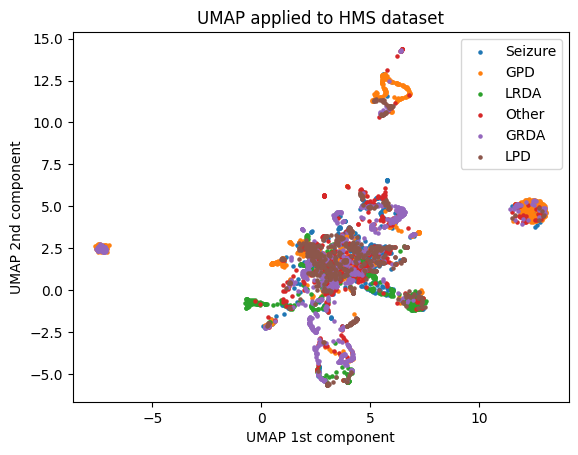

In [8]:
unique_targets = set(target)
inv_mapdict = {value:key for key,value in mapdict.items()}
for t in unique_targets:
    indices = [i for i, value in enumerate(target) if value == t]
    plt.scatter(embedding[indices, 0], embedding[indices, 1], label=inv_mapdict[t], s=5)

plt.xlabel('UMAP 1st component')
plt.ylabel('UMAP 2nd component')
plt.title('UMAP applied to HMS dataset')

plt.legend()

plt.show()